<a href="https://colab.research.google.com/github/Ghazimuhammad/Data_datathon/blob/main/3000_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1**
***Library Imports and Function Declarations***

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Relu Derivative, backpropagation
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Linear activation (output layer)
def linear(x):
    return x

# Linear Derivative (identity)
def linear_derivative(x):
    return 1

def initialize_parameters(layer_sizes):
    parameters = {}
    np.random.seed(1964) #
    for l in range(1, len(layer_sizes)):
        parameters[f'W{l}'] = np.random.randn(layer_sizes[l], layer_sizes[l-1]) * np.sqrt(2. / layer_sizes[l-1])
        parameters[f'b{l}'] = np.zeros((layer_sizes[l], 1))
    return parameters

# Forward pass ANN (forward propagation)
def forward_propagation(X, parameters):
    cache = {}
    A = X.T
    cache['A0'] = A

    for l in range(1, len(parameters) // 2 + 1):
        Z = np.dot(parameters[f'W{l}'], A) + parameters[f'b{l}']
        if l < len(parameters) // 2:
            A = relu(Z)
        else:  # Output layer
            A = linear(Z)

        cache[f'A{l}'] = A
        cache[f'Z{l}'] = Z

    return A, cache

# Compute the MSE loss
def compute_loss_pred(y_true, y_pred):
    m = y_true.shape[1]
    loss = np.sum((y_pred - y_true) ** 2) / (2 * m)
    return loss

def compute_loss_assure(y_true, y_pred):
    m = y_true.shape[0]
    loss = np.sum((y_pred - y_true) ** 2) / (2 * m)
    return loss

# Backward pass ANN (for backpropagation)
def backward_propagation(X, y, cache_pred, parameters):
    m = X.shape[0]
    gradients = {}
    y = y.reshape(-1, 1).T

    dA = cache_pred[f'A{len(parameters)//2}'] - y  # Derivative of loss w.r.t. output

    for l in reversed(range(1, len(parameters) // 2 + 1)):
        dZ = dA * (relu_derivative(cache_pred[f'Z{l}']) if l < len(parameters) // 2 else linear_derivative(cache_pred[f'Z{l}']))
        gradients[f'dW{l}'] = np.dot(dZ, cache_pred[f'A{l-1}'].T) / m
        gradients[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True) / m
        dA = np.dot(parameters[f'W{l}'].T, dZ)

    return gradients

# Update parameters using gradient descent
def update_parameters(parameters, gradients, learning_rate):
    for l in range(1, len(parameters) // 2 + 1):
        parameters[f'W{l}'] -= learning_rate * gradients[f'dW{l}']
        parameters[f'b{l}'] -= learning_rate * gradients[f'db{l}']
    return parameters

def compute_loss_sequential(y_true_seq, y_pred_seq):
    num_samples = len(y_true_seq)
    # Compute the MSE loss for all samples and average it
    loss = np.sum((y_pred_seq - y_true_seq) ** 2) / (2 * num_samples)
    return loss

def normalize(value, Value_min, Value_max):
    return 2 * ((value - Value_min) / (Value_max - Value_min)) - 1

# Make predictions using the trained model
def predict(X, parameters):
    y_pred, _ = forward_propagation(X, parameters)
    return y_pred.T

# **Step 2**
***Model Train (Nonupdating) Function***

In [ ]:
def train_model_nonupdating(X_train, y_train, X_test, y_test, layer_sizes, learning_rate, epochs):
    parameters = initialize_parameters(layer_sizes)
    num_samples = X_train.shape[0]

    y_true_seq = []
    y_pred_seq = []

    loss_values = []
    lossassure_values = []
    epoch_values = []

    for epoch in range(epochs):
        y_true_seq.clear()
        y_pred_seq.clear()

        for i in range(num_samples):
            X_sample = X_train[i].reshape(1, -1)

            y_pred, cache = forward_propagation(X_sample, parameters)

            y_actual = y_train[i]
            y_true_seq.append(y_actual)
            y_pred_seq.append(y_pred[0, 0])

            gradients = backward_propagation(X_sample, y_actual.reshape(1, 1), cache, parameters)
            parameters = update_parameters(parameters, gradients, learning_rate)

        # Calculate the average loss over all samples in this iteration (MSE)
        loss = compute_loss_sequential(np.array(y_true_seq), np.array(y_pred_seq))

        X_assure = X_test
        y_pred_assure, cache_assure = forward_propagation(X_assure, parameters)
        loss_assure = compute_loss_assure(y_test, y_pred_assure)

        # Save the loss for this epoch
        loss_values.append(loss)
        lossassure_values.append(loss_assure)
        epoch_values.append(epoch)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss_train: {loss}, Loss_assure: {loss_assure}')

        if loss_assure < 5e-6:
          print('Loss assure sudah kurang dari 5e-6')
          break

    return parameters, loss_values, lossassure_values, epoch_values

# **Step 3**
***Model Train (Updating) Function***

In [ ]:
def train_model_updating(X_train, y_train, X_test, y_test, parameters, X_min, X_max, learning_rate, epochs):
    X_seq = np.copy(X_train)
    y_seq = np.copy(y_train)

    Value_min = X_min[4]
    Value_max = X_max[4]

    num_samples = X_seq.shape[0]

    y_true_seq = []
    y_pred_seq = []

    loss_values = []
    lossassure_values = []
    epoch_values = []

    for epoch in range(epochs):
        y_true_seq.clear()
        y_pred_seq.clear()

        for i in range(num_samples):
            X_sample = X_train[i].reshape(1, -1)

            y_pred, cache = forward_propagation(X_sample, parameters)

            y_actual = y_train[i]
            y_true_seq.append(y_actual)
            y_pred_seq.append(y_pred[0, 0])

            gradients = backward_propagation(X_sample, y_actual.reshape(1, 1), cache, parameters)
            parameters = update_parameters(parameters, gradients, learning_rate)

            if i + 1 < num_samples:
                #y_pred_normalized = normalize(y_pred[0, 0], Value_min, Value_max)
                #X_seq[i + 1, -3] = y_pred_normalized  # Update Y(k-1)
                X_seq[i + 1, -3] = y_pred  # Update Y(k-1)
                X_seq[i + 1, -2] = X_seq[i, -3]  # Shift Y(k-1) to Y(k-2)
                X_seq[i + 1, -1] = X_seq[i, -2]  # Shift Y(k-2) to Y(k-3)

        # Calculate the average loss over all samples in this iteration (MSE)
        loss = compute_loss_sequential(np.array(y_true_seq), np.array(y_pred_seq))

        X_assure = X_test
        y_pred_assure, cache_assure = forward_propagation(X_assure, parameters)
        loss_assure = compute_loss_assure(y_test, y_pred_assure)

        # Save the loss for this epoch
        loss_values.append(loss)
        lossassure_values.append(loss_assure)
        epoch_values.append(epoch)

        # Optional: Print loss every few iterations
        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Loss_train: {loss}, Loss_assure: {loss_assure}')

        # Early stopping special conditions matched
        if (loss_assure > 1e-6 and epoch > 100) or loss_assure < 1e-7:
            print('Selesai!')
            break
        if (epoch > 30):
          if (lossassure_values[epoch-20] < lossassure_values[epoch]):
            print('Overfitted!')
            print(lossassure_values[epoch-20])
            print(lossassure_values[epoch])
            break

    return parameters, loss_values, lossassure_values, epoch_values


# **Step 4**
***Dataset Loading from Github***

In [ ]:
import random

def generate_data(data_num, seed, data_type):
    # Set the seed for reproducibility
    np.random.seed(seed)

    # Generate input data
    num_points = data_num + 20
    U = np.zeros(num_points)
    sine_period = random.randint(500, 1500)

    if data_type == 'all_random':
        U = 2 * np.random.rand(num_points) - 1  # All data points are random
    elif data_type == 'half_random_half_sine':
        U[:10020] = 2 * np.random.rand(10020) - 1  # First 10000 data points are random
        U[10020:] = np.sin(np.linspace(0, 2 * np.pi * (10000 / sine_period), 10000))  # Next 10000 are sine
    elif data_type == 'all_sine':
        U = np.sin(np.linspace(0, 2 * np.pi * (num_points / 1000), num_points))  # All data points are sine

    # Initialize Y
    Y = 2 * np.random.rand(10) - 1
    Y = np.concatenate([Y, np.zeros(num_points - 10)])  # Extend Y array for computation

    # Compute Y and lagged values
    for n in range(10, num_points):
        Y[n] = (1 / (1 + Y[n - 1])) + 0.25 * U[n] - 0.3 * U[n - 1]

    # Create lagged data arrays
    Umin = U[:-1]
    Umin2 = U[:-2]
    Umin3 = U[:-3]
    Ymin = Y[:-1]
    Ymin2 = Y[:-2]
    Ymin3 = Y[:-3]

    # Create a DataFrame with appropriate columns and cut out the first 20 rows
    data = pd.DataFrame({
        'U(k)': U[20:],
        'U(k-1)': Umin[19:],
        'U(k-2)': Umin2[18:],
        'U(k-3)': Umin3[17:],
        'Y(k)': Y[20:],
        'Y(k-1)': Ymin[19:],
        'Y(k-2)': Ymin2[18:],
        'Y(k-3)': Ymin3[17:]
    })

    # Split input and output
    X = data[['U(k)', 'U(k-1)', 'U(k-2)', 'U(k-3)', 'Y(k-1)', 'Y(k-2)', 'Y(k-3)']].values
    y = data['Y(k)'].values

    return X, y

In [ ]:
X, y = generate_data(data_num=20000, seed=19, data_type='half_random_half_sine')

In [ ]:
# URL raw dari file CSV di GitHub
#url = 'https://raw.githubusercontent.com/StevenJonesAC/SBP2024/refs/heads/main/Data%2010000%20Kedua.csv'

# Mengimpor dataset dari GitHub raw ke dalam DataFrame pandas
#data = pd.read_csv(url)

# Pisahkan input dan output
#X = data[['U(k)', 'U(k-1)', 'U(k-2)', 'U(k-3)', 'Y(k-1)', 'Y(k-2)', 'Y(k-3)']].values  # Ganti nama kolom sesuai dataset Anda
#y = data['Y(k)'].values  # Nama kolom output yang sesuai

# **Step 3**
***Data Preprocessing***

In [ ]:
# Normalisasi data input secara manual menggunakan numpy
X_min = np.min(X, axis=0)
X_max = np.max(X, axis=0)
X_scaled = 2 * ((X - X_min) / (X_max - X_min)) - 1

# Mengetahui matriks X_min dan X_max
print(X_min)
print(X_max)

# Create a DataFrame with X before and after normalization
df_beforeN = pd.DataFrame(X, columns=['U(k)', 'U(k-1)', 'U(k-2)', 'U(k-3)', 'Y(k-1)', 'Y(k-2)', 'Y(k-3)'])
df_afterN = pd.DataFrame(X_scaled, columns=['U(k)', 'U(k-1)', 'U(k-2)', 'U(k-3)', 'Y(k-1)', 'Y(k-2)', 'Y(k-3)'])

# Concatenate before and after normalization
df_combined = pd.concat([df_beforeN.add_suffix('_before_normalization'),
                         df_afterN.add_suffix('_after_normalization')], axis=1)

print(df_combined.head())

[-0.99999997 -0.99999997 -0.99999997 -0.99999997 -0.08601579 -0.08601579
 -0.08601579]
[1.         1.         1.         1.         1.57358697 1.57358697
 1.57358697]
   U(k)_before_normalization  U(k-1)_before_normalization  \
0                  -0.254146                     0.376655   
1                   0.892320                    -0.254146   
2                   0.554716                     0.892320   
3                   0.216069                     0.554716   
4                   0.230464                     0.216069   

   U(k-2)_before_normalization  U(k-3)_before_normalization  \
0                    -0.225986                     0.065372   
1                     0.376655                    -0.225986   
2                    -0.254146                     0.376655   
3                     0.892320                    -0.254146   
4                     0.554716                     0.892320   

   Y(k-1)_before_normalization  Y(k-2)_before_normalization  \
0                     0.

# **Step 4**
***Dataset Splitting***

In [ ]:
# Membagi dataset secara manual (misalnya 80% untuk training dan 20% untuk testing)
split_ratio = 0.7
split_index = int(split_ratio * len(X))

X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# **Step 5**
***The ANN Model***

In [ ]:
# Model dengan lebih banyak neuron dan layer
layer_sizes = [7, 128, 1]  # Menambah jumlah neuron di setiap layer

[parameters, loss_values, lossassure_values, epoch_values] = train_model_nonupdating(X_train, y_train, X_test, y_test, layer_sizes, learning_rate=0.07, epochs=4000)

# Make predictions on test data
y_pred = predict(X_test, parameters)

Epoch 0, Loss_train: 0.03471658392034881, Loss_assure: 0.003076098713587444
Epoch 10, Loss_train: 2.122319030248294e-05, Loss_assure: 0.0001508133576177224
Epoch 20, Loss_train: 1.3603332988015882e-05, Loss_assure: 0.00010830177008051637
Epoch 30, Loss_train: 1.0394482800731102e-05, Loss_assure: 7.456798001400532e-05
Epoch 40, Loss_train: 8.483972792866068e-06, Loss_assure: 6.479511607487971e-05
Epoch 50, Loss_train: 7.213184177220197e-06, Loss_assure: 6.599871468216807e-05
Epoch 60, Loss_train: 6.283262153059544e-06, Loss_assure: 6.861952245784e-05
Epoch 70, Loss_train: 5.562388927845314e-06, Loss_assure: 6.786991574851585e-05
Epoch 80, Loss_train: 5.003876781042644e-06, Loss_assure: 6.408179779984677e-05
Epoch 90, Loss_train: 4.587848116581718e-06, Loss_assure: 5.7648518195487755e-05
Epoch 100, Loss_train: 4.264678542506806e-06, Loss_assure: 5.2713278629152074e-05
Epoch 110, Loss_train: 4.001575404440141e-06, Loss_assure: 5.215877870567996e-05
Epoch 120, Loss_train: 3.787476923238737

KeyboardInterrupt: 

# **Step 6**
***ANN Output Comparison***

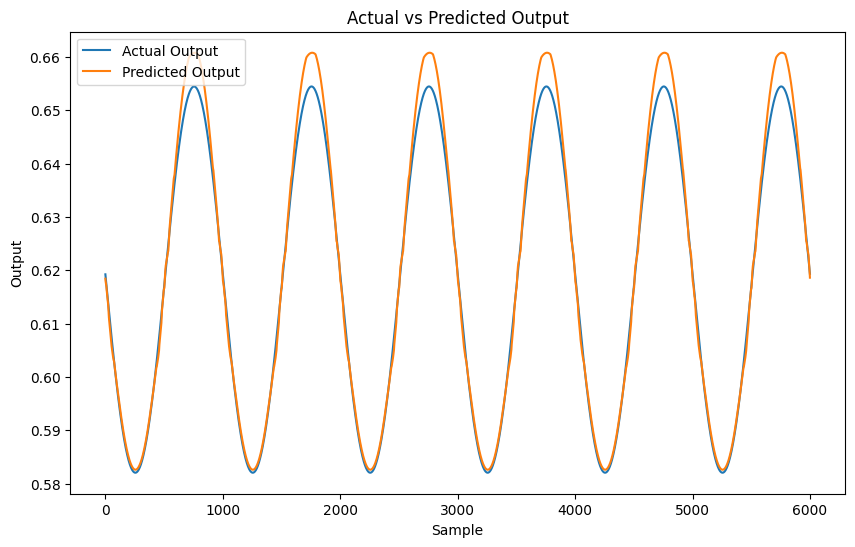

    Actual Output  Predicted Output
0        0.619245          0.618430
1        0.619017          0.618018
2        0.618790          0.617927
3        0.618562          0.617798
4        0.618335          0.617669
5        0.618107          0.617531
6        0.617880          0.617382
7        0.617652          0.617233
8        0.617425          0.617084
9        0.617197          0.616906
10       0.616970          0.616494
11       0.616743          0.616284
12       0.616515          0.616075
13       0.616288          0.615854
14       0.616061          0.615618
15       0.615834          0.615356
16       0.615607          0.615171
17       0.615381          0.614997
18       0.615154          0.614979
19       0.614928          0.614773
20       0.614701          0.614508
21       0.614475          0.614243
22       0.614249          0.613978
23       0.614023          0.613714
24       0.613797          0.613449
25       0.613572          0.613027
26       0.613347          0

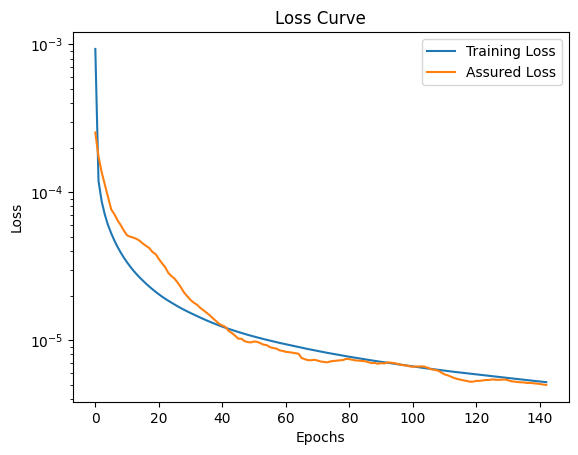

In [ ]:
# Plot hasil prediksi vs data nyata
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Output')
plt.plot(y_pred, label='Predicted Output')
plt.title('Actual vs Predicted Output')
plt.xlabel('Sample')
plt.ylabel('Output')
plt.legend()
plt.show()

# Membuat DataFrame untuk membandingkan hasil aktual dengan prediksi
comparison_df = pd.DataFrame({
    'Actual Output': y_test,
    'Predicted Output': y_pred.flatten()  # Flatten karena hasil prediksi berbentuk array 2D
})

# Tampilkan beberapa baris pertama dari tabel
print(comparison_df.head(30))

# After training, plot the loss curve
plt.semilogy(epoch_values, loss_values, label='Training Loss')
plt.semilogy(epoch_values, lossassure_values, label='Assured Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# **Step 7**
***Training Using Real-Time Data***

In [ ]:
[parameters_seq, loss_values, lossassure_values, epoch_values] = train_model_updating(X_train, y_train, X_test, y_test, parameters, X_min, X_max, learning_rate=0.02, epochs=1000)

# Make predictions on test data
y_pred = predict(X_test, parameters_seq)

<ipython-input-47-f76663188371>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_seq[i + 1, -3] = y_pred  # Update Y(k-1)


Epoch 0, Loss_train: 3.099975978591678e-06, Loss_assure: 2.1120725323811664e-07
Epoch 5, Loss_train: 3.090454565468788e-06, Loss_assure: 2.0964665463934046e-07
Epoch 10, Loss_train: 3.0812078390227636e-06, Loss_assure: 2.080126274533618e-07
Epoch 15, Loss_train: 3.0717849734373574e-06, Loss_assure: 2.079602044078405e-07
Epoch 20, Loss_train: 3.062141694710174e-06, Loss_assure: 2.0580614874855522e-07
Epoch 25, Loss_train: 3.0527403311994024e-06, Loss_assure: 2.0423435669567628e-07
Epoch 30, Loss_train: 3.0433786796090504e-06, Loss_assure: 2.0314767702815565e-07
Epoch 35, Loss_train: 3.0342351467045047e-06, Loss_assure: 2.0209988551282138e-07
Epoch 40, Loss_train: 3.025175865873134e-06, Loss_assure: 2.005599419898258e-07
Epoch 45, Loss_train: 3.016143249244724e-06, Loss_assure: 2.0015171735278698e-07
Epoch 50, Loss_train: 3.006961652316852e-06, Loss_assure: 2.0202486561655634e-07
Epoch 55, Loss_train: 2.9979334465197734e-06, Loss_assure: 2.006776118021648e-07
Epoch 60, Loss_train: 2.9889

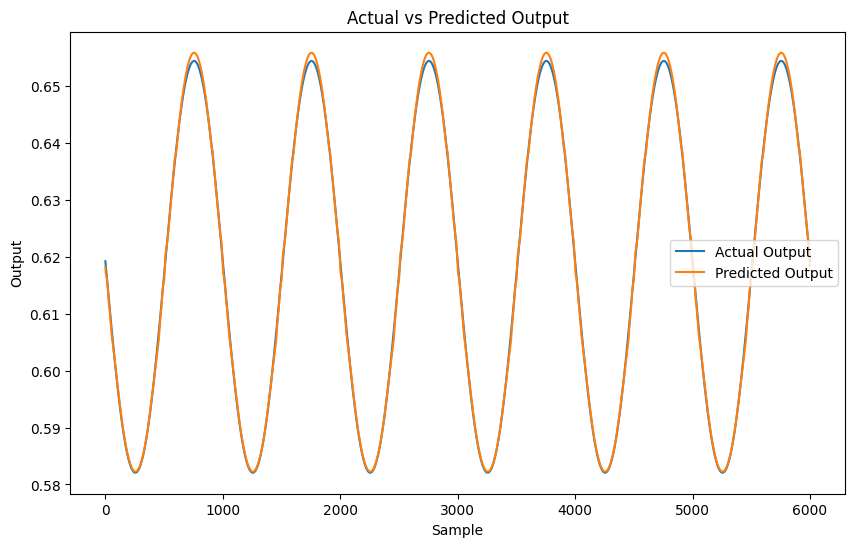

    Actual Output  Predicted Output
0        0.619245          0.618247
1        0.619017          0.617802
2        0.618790          0.617357
3        0.618562          0.617140
4        0.618335          0.617045
5        0.618107          0.616949
6        0.617880          0.616853
7        0.617652          0.616758
8        0.617425          0.616662
9        0.617197          0.616566
10       0.616970          0.616500
11       0.616743          0.616435
12       0.616515          0.616246
13       0.616288          0.616056
14       0.616061          0.615867
15       0.615834          0.615645
16       0.615607          0.615409
17       0.615381          0.615173
18       0.615154          0.615059
19       0.614928          0.614967
20       0.614701          0.614736
21       0.614475          0.614417
22       0.614249          0.614105
23       0.614023          0.613794
24       0.613797          0.613477
25       0.613572          0.613146
26       0.613347          0

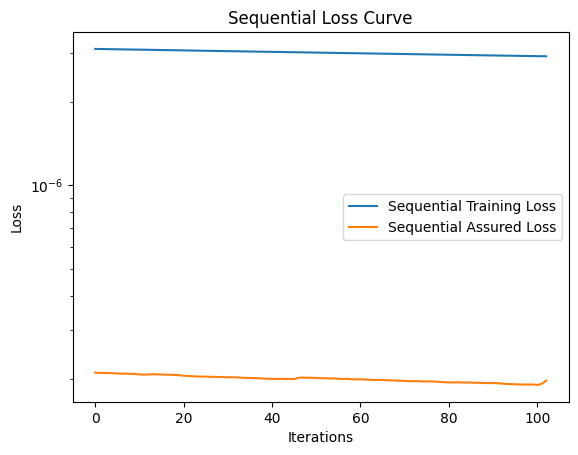

Final Testing Loss: 1.9761972943361558e-07


In [ ]:
# Plot hasil prediksi vs data nyata
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Output')
plt.plot(y_pred, label='Predicted Output')
plt.title('Actual vs Predicted Output')
plt.xlabel('Sample')
plt.ylabel('Output')
plt.legend()
plt.show()

# Membuat DataFrame untuk membandingkan hasil aktual dengan prediksi
comparison_df = pd.DataFrame({
    'Actual Output': y_test,
    'Predicted Output': y_pred.flatten()  # Flatten karena hasil prediksi berbentuk array 2D
})

# Tampilkan beberapa baris pertama dari tabel
print(comparison_df.head(30))

# After training, plot the loss curve
plt.semilogy(epoch_values, loss_values, label='Sequential Training Loss')
plt.semilogy(epoch_values, lossassure_values, label='Sequential Assured Loss')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Sequential Loss Curve')
plt.legend()
plt.show()

num_samples = len(y_pred)
# Compute the MSE loss for all samples and average it
loss_x = np.sum((y_pred.flatten() - y_test) ** 2) / (2 * num_samples)
print(f'Final Testing Loss: {loss_x}')

In [ ]:
# URL raw dari file CSV di GitHub
url_rand = 'https://raw.githubusercontent.com/StevenJonesAC/SBP2024/refs/heads/main/Data%2010000%207%20Variabel.csv'
url_sine = 'https://raw.githubusercontent.com/StevenJonesAC/SBP2024/refs/heads/main/Data%2010000%20Sinus.csv'

# Mengimpor dataset dari GitHub raw ke dalam DataFrame pandas
data_rand = pd.read_csv(url_rand)
data_sine = pd.read_csv(url_sine)

# Pisahkan input dan output
#X_rand = data_rand[['U(k)', 'U(k-1)', 'U(k-2)', 'U(k-3)', 'Y(k-1)', 'Y(k-2)', 'Y(k-3)']].values
#y_rand = data_rand['Y(k)'].values  # Nama kolom output yang sesuai

# Pisahkan input dan output
#X_sine = data_sine[['U(k)', 'U(k-1)', 'U(k-2)', 'U(k-3)', 'Y(k-1)', 'Y(k-2)', 'Y(k-3)']].values
#y_sine = data_sine['Y(k)'].values

# Pisahkan input dan output
X_rand, y_rand = generate_data(seed=1922, data_type='all_random')

# Pisahkan input dan output
X_sine, y_sine = generate_data(seed=9841, data_type='half_random_half_sine')

# Normalisasi data input secara manual menggunakan numpy
X_min_rand = np.min(X_rand, axis=0)
X_max_rand = np.max(X_rand, axis=0)
X_scaled_rand = 2 * ((X_rand - X_min_rand) / (X_max - X_min_rand)) - 1

# Normalisasi data input secara manual menggunakan numpy
X_min_sine = np.min(X_sine, axis=0)
X_max_sine = np.max(X_sine, axis=0)
X_scaled_sine = 2 * ((X_sine - X_min_sine) / (X_max - X_min_sine)) - 1

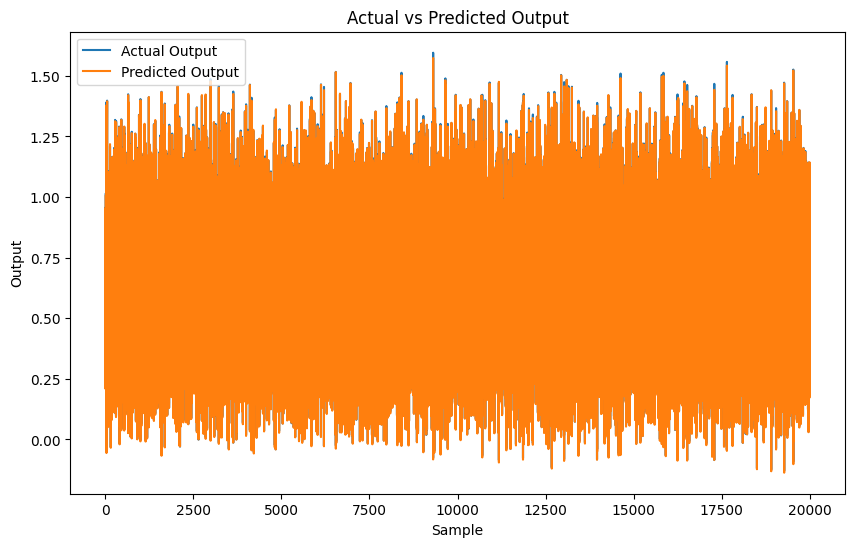

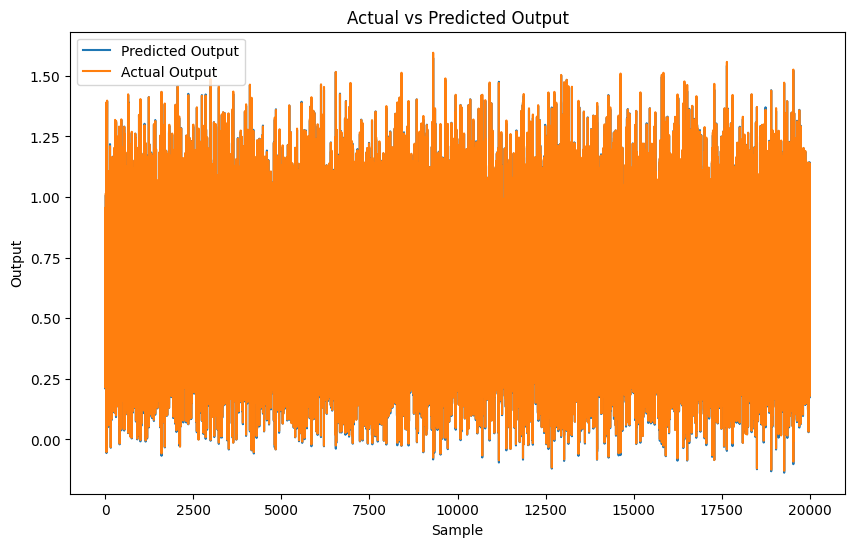

Final Testing Loss: 2.7356455017366505e-05
    Actual Output  Predicted Output
0        0.684044          0.686684
1        0.690923          0.692454
2        0.955995          0.953579
3        0.213661          0.209341
4        0.657327          0.649410
5        0.895173          0.889791
6        0.622005          0.626979
7        0.308988          0.301377
8        0.862185          0.859576
9        0.609101          0.602025
10       0.861208          0.857545
11       0.532520          0.526092
12       0.675105          0.674502
13       0.404782          0.408513
14       0.685491          0.679076
15       0.270248          0.268478
16       1.015241          1.007695
17       0.774690          0.767315
18       0.355704          0.352748
19       0.767877          0.768322
20       0.533397          0.529816
21       0.686030          0.686147
22       0.397428          0.387199
23       0.506247          0.501292
24       0.794636          0.791428
25       0.914292    

In [ ]:
y_pred_rand = predict(X_scaled_rand, parameters_seq)
#loss_rand = compute_loss_pred(y_rand, y_pred_rand)
loss_rand = np.sum((y_pred_rand.flatten() - y_rand) ** 2) / (2 * 10000)

# Plot hasil prediksi vs data nyata
plt.figure(figsize=(10,6))
plt.plot(y_rand, label='Actual Output')
plt.plot(y_pred_rand, label='Predicted Output')
plt.title('Actual vs Predicted Output')
plt.xlabel('Sample')
plt.ylabel('Output')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(y_pred_rand, label='Predicted Output')
plt.plot(y_rand, label='Actual Output')
plt.title('Actual vs Predicted Output')
plt.xlabel('Sample')
plt.ylabel('Output')
plt.legend()
plt.show()

# Membuat DataFrame untuk membandingkan hasil aktual dengan prediksi
comparison_df = pd.DataFrame({
    'Actual Output': y_rand,
    'Predicted Output': y_pred_rand.flatten()  # Flatten karena hasil prediksi berbentuk array 2D
})

print(f'Final Testing Loss: {loss_rand}')

# Tampilkan beberapa baris pertama dari tabel
print(comparison_df.head(30))

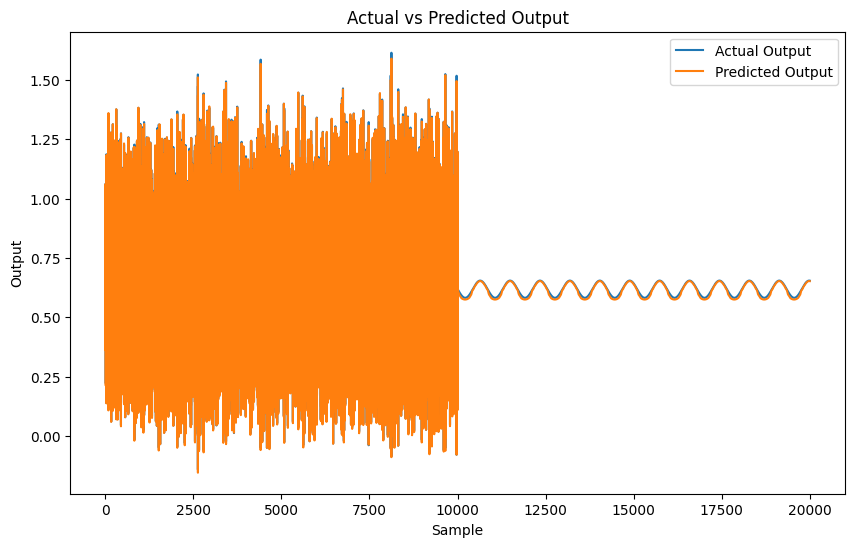

Final Testing Loss: 4.56127442858667e-05
    Actual Output  Predicted Output
0        0.372586          0.363297
1        1.060776          1.059867
2        0.362371          0.362542
3        0.927882          0.925435
4        0.410500          0.402590
5        0.455451          0.445682
6        0.585567          0.582635
7        0.676912          0.678462
8        0.610631          0.607945
9        0.801118          0.796622
10       0.414952          0.411759
11       1.006704          0.997769
12       0.662343          0.665168
13       0.596623          0.590653
14       0.221788          0.212488
15       0.762088          0.764929
16       0.891905          0.887126
17       0.612387          0.613114
18       0.489560          0.484684
19       0.390874          0.383586
20       0.939162          0.936083
21       0.377219          0.373746
22       0.736077          0.732469
23       0.556715          0.552884
24       0.881958          0.876471
25       0.469543      

In [ ]:
y_pred_sine = predict(X_scaled_sine, parameters_seq)
loss_sine = np.sum((y_pred_sine.flatten() - y_sine) ** 2) / (2 * 10000)

# Plot hasil prediksi vs data nyata
plt.figure(figsize=(10,6))
plt.plot(y_sine, label='Actual Output')
plt.plot(y_pred_sine, label='Predicted Output')
plt.title('Actual vs Predicted Output')
plt.xlabel('Sample')
plt.ylabel('Output')
plt.legend()
plt.show()

# Membuat DataFrame untuk membandingkan hasil aktual dengan prediksi
comparison_df = pd.DataFrame({
    'Actual Output': y_sine,
    'Predicted Output': y_pred_sine.flatten()  # Flatten karena hasil prediksi berbentuk array 2D
})

print(f'Final Testing Loss: {loss_sine}')

# Tampilkan beberapa baris pertama dari tabel
print(comparison_df.head(30))